In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns
import scipy

In [68]:
def create_files():
    column_labels=['time', 'regret', 'violation']
    df=pd.DataFrame(columns=column_labels)
    df.to_csv('Hazan2016-Final.csv',index=False)
    df.to_csv('Hazan2020_nonsmooth-Final.csv',index=False)
    df.to_csv('Hazan2020_smooth-Final.csv',index=False)
    df.to_csv('Xie2020-Final.csv',index=False)

In [70]:
create_files()

In [9]:
def Objective(X, M, OB):
    return sum([(1/2)*(X[i]-M[i])**2 if i in OB else 0 for i in range(0,2500)])
        
def gradient(X, M, OB):
    return np.array([(X[i]-M[i]) if i in OB else 0 for i in range(0,2500)], dtype='float64')
    

def Hazan_2016_final(X_init, M, OB_list, g, T, k):
    Q=math.floor(T**(1/3))
    K=math.floor(T**(2/3))
    X=X_init.flatten()
    X_init=X_init.flatten()
    M=M.flatten()
    mu=1/(2400*(T**(1/2))*(Q+1))
    Regret=0
    violation=0
    dual=0
    Nabla=np.array([0 for i in range(0,2500)], dtype='float64')
    eta=1/(8*(K**(3/4)))
    t=1
    for q in range(1,Q+1):
        G=0
        Nabla=np.array([0 for i in range(0,2500)], dtype='float64')
        for m in range(1,K+1):
            if t==1:
                Regret=Regret+Objective(X, M, OB_list[t])
                violation=violation+g[t].dot(X)
                G=G+g[t].dot(X)
                Nabla=Nabla+eta*(gradient(X, M, OB_list[t])+dual*g[t])
            else:
                Regret=Regret+Objective(X, M, OB_list[t])
                violation=violation+g[t].dot(X)
                G=G+g[t].dot(X)
                grad=np.reshape(Nabla+2*(X-X_init),(50,50))
                U,s,V=np.linalg.svd((-1)*grad)
                Nabla=Nabla+eta*(gradient(X, M, OB_list[t])+dual*g[t])
                u1=U[:,0]
                v1=V[0]
                v=k*(np.outer(u1,v1)).flatten()
                step_size=min(1,2/(m**1/2))
                X=(1-step_size)*X+step_size*v
            t+=1
        dual=max(0,(Q/(Q+1))*dual+mu*G)
    return Regret, violation, t-1
    
def Hazan_2020_nonsmooth_final(M, OB_list, g, T, k):
    Q=math.floor(T**(1/2))
    K=math.floor(T**(1/2))
    M=M.flatten()
    delta=1/(50*(K**(1/2)))
    mu=1/(3060*(T**(1/4))*(Q+1)) 
    Regret=0
    violation=0
    dual=0
    Nabla=np.array([0 for i in range(0,2500)], dtype='float64')
    t=1
    for q in range(1,Q+1):
        G=0
        Nabla=np.array([0 for i in range(0,2500)], dtype='float64')
        for m in range(1,K+1):
            X=np.array([0 for i in range(0,2500)], dtype='float64')
            for n in range(1,K+1):
                rr=np.random.uniform(0,1)
                w=np.random.normal(size=2500)
                w=w/np.linalg.norm(w)
                w=w * (rr**(1/2500))
                Grad=np.reshape(-Nabla+(w/delta),(50,50))
                U,s,V=np.linalg.svd(Grad)
                u1=U[:,0]
                v1=V[0]
                X=X+(1/K)*k*(np.outer(u1,v1).flatten())
            Regret+=Objective(X, M, OB_list[t])
            violation+=g[t].dot(X)
            G+=g[t].dot(X)
            Nabla+=(gradient(X, M, OB_list[t])+dual*g[t])
            t+=1
        dual=max(0,(Q/(Q+1))*dual+mu*G)
    return Regret, violation, t-1
            
                                  
def Hazan_2020_smooth_final(X_init, M, OB_list, g, T, k):
    Q=math.floor(T**(2/5))
    K=math.floor(T**(3/5))
    b=math.floor(K**(1/3))
    delta=1/(50*(K**(1/2)))
    mu=1/(5050*3*(T**(2/5))*(Q+1))
    M=M.flatten()
    X=X_init.flatten()
    dual=0
    Regret=0
    violation=0
    Nabla=np.array([0 for i in range(0,2500)], dtype='float64')
    t=1
    for q in range(1,Q+1):
        G=0
        Nabla=np.array([0 for i in range(0,2500)], dtype='float64')
        for m in range(1,K+1):
            if m%b==0:
                X=np.array([0 for i in range(0,2500)], dtype='float64')
                for n in range(0,b):
                    rr=np.random.uniform(0,1)
                    w=np.random.normal(size=2500)
                    w=w/np.linalg.norm(w)
                    w=w * (rr**(1/2500))
                    Grad=np.reshape(-Nabla+(w/delta),(50,50))
                    U,s,V=np.linalg.svd(Grad)
                    v1=V[0]
                    u1=U[:,0]
                    X+=(1/b)*(k*np.outer(u1,v1)).flatten()
            Regret+=Objective(X, M, OB_list[t])
            violation+=g[t].dot(X)
            G+=g[t].dot(X)
            Nabla+=(gradient(X, M, OB_list[t])+dual*g[t])
            t+=1
        dual=max(0,(Q/(Q+1))*dual+mu*G)
    return Regret, violation, t-1
   

def Xie2020(X_init, M, OB_list, g, T, k):
    Q=math.floor(T**(1/2)/np.log(T))
    K=math.floor(T**(1/2)*np.log(T))
    mu=1/(3*16*20*25*(T**(1/4))*(Q+1))
    M=M.flatten()
    Regret=0
    violation=0
    dual=0
    t=1 
    for q in range(1,Q+1):
        G=0
        d=np.array([0]*2500, dtype='float64')
        #print('finish')
        X=X_init.flatten()
        Y=X_init.flatten()
        for m in range(1,K+1):
            Regret+=Objective(Y, M, OB_list[t])
            #print(Objective(Y, M, OB_list[t]))
            violation+=g[t].dot(Y)
            G+=g[t].dot(Y)
            Nabla_1=gradient(X, M, OB_list[t])+dual*g[t]
            Nabla_2=gradient(Y, M, OB_list[t])+dual*g[t]
            if m==1:
                d=Nabla_2
            else:
                d=(Nabla_2+(m/(m+1))*(d-Nabla_1))
            U, s, V=np.linalg.svd(np.reshape((-1)*d,(50,50)))
            u1=U[:,0]
            v1=V[0]
            v=k*(np.outer(u1,v1).flatten())
            X=Y
            Y=(m/(m+1))*Y+(1/(m+1))*v
            t+=1
        dual=max(0,(Q/(Q+1))*dual+mu*G)
    return Regret, violation, t-1
        
            
            
                
            
    

                
def Primal_Dual_Meta_FW(X_init, M, OB_list, g, T, k):
    M=M.flatten()
    Regret=0
    violation=0
    dual=0
    mu=(T**(1/2))/(15*(10**3)*(T+2))
    delta=1/(100*(T**(1/2)))
    X=X_init.flatten()
    K=math.floor(T**(1/2))
    Nabla=np.array([np.random.uniform(0,delta,2500) for j in range(0,K)], dtype='float64')
    for t in range(1,T+1):
        if t==1:
            Regret+=Objective(X, M, OB_list[t])
            violation+=g[t].dot(X)
            Y=X
        else:
            Regret+=Objective(X, M, OB_list[t])
            violation+=g[t].dot(X)
            X=X_init.flatten() 
            for i in range(1,K+1):
                grad=np.reshape(Nabla[i-1],(50,50)) 
                U,s,V=np.linalg.svd(-grad)
                Nabla[i-1]+=gradient(X, M, OB_list[t])+dual*g[t]
                u1=U[:,0]
                v1=V[0]
                step_size=2/(i+1)
                X=(1-step_size)*X+step_size*((k*np.outer(u1,v1)).flatten())
            Y=X
        dual=max(0,((T+1)/(T+2))*dual+mu*g[t].dot(X))
        X=Y
    return Regret, violation
    
    

               
        
            
            
            
               

    



    


In [71]:
T=10001
m=50 #the number of rows 
n=50 #the number of columns
k=5 #rank
B=100 #the number of known entries.

X_init=np.zeros((50,50))
    
number_instance=30

for instance in range(0,number_instance):
    print(instance)
    time_interval=[10*i for i in range(1,10)]+[100*i for i in range(1,11)]+[1500]
    g=[np.random.uniform(-1,1,2500) for i in range(0,T+1)]
    Um = np.random.normal(0, 1, (50, 10))
    Um = np.linalg.qr(Um)[0]
    S = np.diag(np.random.uniform(0, 1, 10))
    S /= np.sum(S)
    S = S
    M = Um.dot(S.dot(Um.T))
    OB_list=np.array([random.sample(range(0,2500),B) for i in range(0,T+1)]) #collection of observed-entries sets
    for time in time_interval:
        print(time)
        Hazan2016_reg, Hazan2016_vio, t1=Hazan_2016_final(X_init, M, OB_list, g, time, k)
        
        Hazan2016_df = pd.read_csv('Hazan2016-Final.csv')
        Hazan2016_df1 = pd.DataFrame({'time':[t1], 'regret':[Hazan2016_reg/t1], 'violation':[Hazan2016_vio/t1]})
        Hazan2016_df = pd.concat([Hazan2016_df,Hazan2016_df1]) 
        Hazan2016_df.to_csv('Hazan2016-Final.csv', index=False) 
        
        Hazan2020nonsmooth_reg, Hazan2020nonsmooth_vio, t2=Hazan_2020_nonsmooth_final(M, OB_list, g, time, k)
        
        Hazan2020nonsmooth_df = pd.read_csv('Hazan2020_nonsmooth-Final.csv')
        Hazan2020nonsmooth_df1 = pd.DataFrame({'time':[t2], 'regret':[Hazan2020nonsmooth_reg/t2], 'violation':[Hazan2020nonsmooth_vio/t2]})
        Hazan2020nonsmooth_df = pd.concat([Hazan2020nonsmooth_df,Hazan2020nonsmooth_df1]) 
        Hazan2020nonsmooth_df.to_csv('Hazan2020_nonsmooth-Final.csv', index=False) 
        
        Hazan2020smooth_reg, Hazan2020smooth_vio, t3=Hazan_2020_smooth_final(X_init, M, OB_list, g, time, k)
        
        Hazan2020smooth_df = pd.read_csv('Hazan2020_smooth-Final.csv')
        Hazan2020smooth_df1 = pd.DataFrame({'time':[t3], 'regret':[Hazan2020smooth_reg/t3], 'violation':[Hazan2020smooth_vio/t3]})
        Hazan2020smooth_df = pd.concat([Hazan2020smooth_df,Hazan2020smooth_df1]) 
        Hazan2020smooth_df.to_csv('Hazan2020_smooth-Final.csv', index=False) 
        
        Xie2020_reg, Xie2020_vio, t4=Xie2020(X_init, M, OB_list, g, time, k)
        
        Xie2020_df=pd.read_csv('Xie2020-Final.csv')
        Xie2020_df1=pd.DataFrame({'time':[t4], 'regret':[Xie2020_reg/t4], 'violation':[Xie2020_vio/t4]})
        Xie2020_df = pd.concat([Xie2020_df,Xie2020_df1]) 
        Xie2020_df.to_csv('Xie2020-Final.csv', index=False)
    
        #PDMFW_reg, PDMFW_vio=Primal_Dual_Meta_FW(X_init, M, OB_list, g, time, k)
        
        #PDMFW_df = pd.read_csv('PDMFW-f1.csv')
        #PDMFW_df1 = pd.DataFrame({'time':[time], 'regret':[PDMFW_reg/time], 'violation':[PDMFW_vio/time]})
        #PDMFW_df = pd.concat([PDMFW_df,PDMFW_df1]) 
        #PDMFW_df.to_csv('PDMFW-f1.csv', index=False)
    
    
    
    
     
     
         
        
        
        
    

0
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
1500
1
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
1500
2
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
1500
3
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
1500
4
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
1500
5
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
1500
6
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
1500
7
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
1500
8
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
1500
9
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
1500
10
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
1500
11
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
1500
12
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
1500
13
10
20
30
40
50
60
7

In [39]:
Df=pd.read_csv('Hazan2016-f.csv')
filt=(Df['time']<=1000)
filtered=Df[filt]
filtered.to_csv('Hazan2016-f.csv',index=False)

In [40]:
Df=pd.read_csv('Hazan2020_nonsmooth-f.csv')
filt=(Df['time']<=1000)
filtered=Df[filt]
filtered.to_csv('Hazan2020_nonsmooth-f.csv',index=False)

In [41]:
Df=pd.read_csv('Hazan2020_smooth-f.csv')
filt=(Df['time']<=1000)
filtered=Df[filt]
filtered.to_csv('Hazan2020_smooth-f.csv',index=False)

In [42]:
Df=pd.read_csv('Xie2020-f.csv')
filt=(Df['time']<=1000)
filtered=Df[filt]
filtered.to_csv('Xie2020-f.csv',index=True, index_label='id')

In [44]:
H16_1=pd.read_csv('Hazan2016-final.csv')
H16_2=pd.read_csv('Hazan2016-f.csv')
New_H16=pd.concat([H16_1,H16_2])
New_H16.to_csv('Hazan2016-Final', index=False)

In [45]:
H20ns_1=pd.read_csv('Hazan2020_nonsmooth-final.csv')
H20ns_2=pd.read_csv('Hazan2020_nonsmooth-f.csv')
New_H20ns=pd.concat([H20ns_1,H20ns_2])
New_H20ns.to_csv('Hazan2020_nonsmooth-Final', index=False)

In [46]:
H20s_1=pd.read_csv('Hazan2020_smooth-final.csv')
H20s_2=pd.read_csv('Hazan2020_smooth-f.csv')
New_H20s=pd.concat([H20s_1,H20s_2])
New_H20s.to_csv('Hazan2020_smooth-Final', index=False)

In [47]:
Xie_1=pd.read_csv('Xie2020-final.csv')
Xie_2=pd.read_csv('Xie2020-f.csv')
New_Xie=pd.concat([Xie_1,Xie_2])
New_Xie.to_csv('Xie2020-Final', index=False)

In [48]:
mfw_1=pd.read_csv('PDMFW-final.csv')
mfw_2=pd.read_csv('PDMFW-f.csv')
New_mfw=pd.concat([mfw_1,mfw_2])
New_mfw.to_csv('PDMFW-Final', index=False)

In [72]:
Hazan16_df=pd.read_csv('Hazan2016-Final')
Hazan20nonsmooth_df=pd.read_csv('Hazan2020_nonsmooth-Final')
Hazan20smooth_df=pd.read_csv('Hazan2020_smooth-Final')
Xie20_df=pd.read_csv('Xie2020-Final')
PDMFW_df=pd.read_csv('PDMFW-Final')
sns.lineplot(x=Hazan16_df['time'], y=Hazan16_df['regret'], label='Hazan2016')
sns.lineplot(x=Hazan20nonsmooth_df['time'], y=Hazan20nonsmooth_df['regret'], label='Hazan2020nonsmooth')
sns.lineplot(x=Hazan20smooth_df['time'], y=Hazan20smooth_df['regret'], label='Hazan2020smooth')
sns.lineplot(x=Xie20_df['time'], y=Xie20_df['regret'], label='Xie2020')
sns.lineplot(x=PDMFW_df['time'], y=PDMFW_df['regret'], label='PDMFW')
plt.legend(fontsize=7)
plt.xlabel('number of iterations',fontsize=18)
plt.ylabel('Regret',fontsize=18)


ValueError: Could not interpret value `regret` for parameter `style`

Text(0, 0.5, 'Violation')

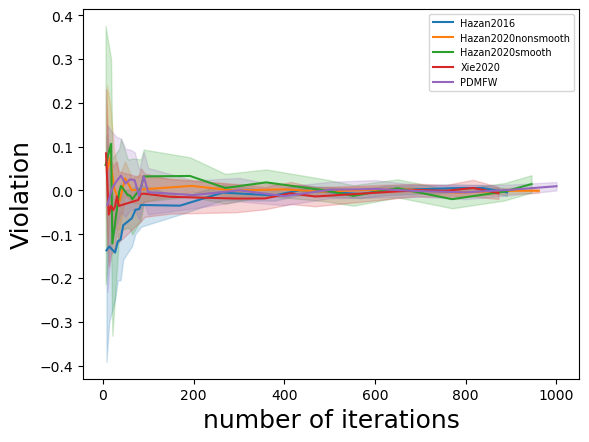

In [55]:
Hazan16_df=pd.read_csv('Hazan2016-Final')
Hazan20nonsmooth_df=pd.read_csv('Hazan2020_nonsmooth-Final')
Hazan20smooth_df=pd.read_csv('Hazan2020_smooth-Final')
Xie20_df=pd.read_csv('Xie2020-Final')
PDMFW_df=pd.read_csv('PDMFW-Final')
sns.lineplot(x=Hazan16_df['time'], y=Hazan16_df['violation'], label='Hazan2016')
sns.lineplot(x=Hazan20nonsmooth_df['time'], y=Hazan20nonsmooth_df['violation'], label='Hazan2020nonsmooth')
sns.lineplot(x=Hazan20smooth_df['time'], y=Hazan20smooth_df['violation'], label='Hazan2020smooth')
sns.lineplot(x=Xie20_df['time'], y=Xie20_df['violation'], label='Xie2020')
sns.lineplot(x=PDMFW_df['time'], y=PDMFW_df['violation'], label='PDMFW')
plt.legend(fontsize=7)

plt.xlabel('number of iterations',fontsize=18)
plt.ylabel('Violation',fontsize=18)

In [ ]:
plt.plot(Hazan16)
plt.plot(Hazan20nsm)
plt.plot(Hazan20sm)
plt.plot(Xie20)          

In [ ]:
[0]*20